In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
%matplotlib inlinetrain.shape

In [2]:
train = pd.read_csv("Train.csv")
Train_AccountInfo = pd.read_csv("Train_AccountInfo.csv")
Train_Demographics = pd.read_csv("Train_Demographics.csv")
Train_ServicesOptedFor = pd.read_csv("Train_ServicesOptedFor.csv")

In [3]:
train.shape

(5298, 2)

In [4]:
train.head()

,CustomerID,Churn
0,Cust4327,Yes
1,Cust3826,No
2,Cust6200,No
3,Cust1467,No
4,Cust4843,No


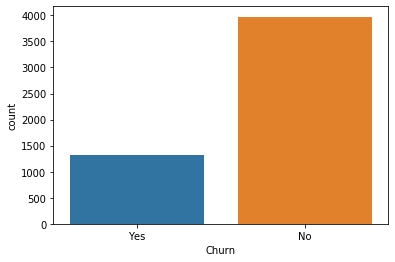

In [5]:
sns.countplot(x="Churn", data=train)

The data is highly imbalanced..


In [6]:
Train_AccountInfo.shape
Train_AccountInfo.head()

,CustomerID,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod
0,Cust1450,417.75,5-1-2012,3400.25,10-May-11,Yes,Month-to-month,Electronic check
1,Cust4452,500.00,5-1-2012,7673.75,12-Sep-10,Yes,Month-to-month,Electronic check
2,Cust1681,394.00,5-1-2012,8206.5,15-May-10,No,Month-to-month,Electronic check
3,Cust4761,398.75,5-1-2012,5559.25,12-Oct-10,Yes,Month-to-month,Electronic check
4,Cust1785,447.25,5-1-2012,4265.5,10-Apr-11,No,Month-to-month,Electronic check


In [7]:
#taking the first record in train_accounntinfo and checking in train data to know wheeather to merge or not
train[train.CustomerID == "Cust1450"]

,CustomerID,Churn
3817,Cust1450,Yes


# Data Cleaning 

In [8]:
#merging two dataframes with customerid attribute
train_train_account= pd.merge(Train_AccountInfo,train,on="CustomerID")
train_train_account[train_train_account.CustomerID == "Cust1450"] #checking the merged dataframe

,CustomerID,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1450,417.75,5-1-2012,3400.25,10-May-11,Yes,Month-to-month,Electronic check,Yes


In [9]:
#Train_Demographics
print(Train_Demographics.shape)
Train_Demographics.head()
Train_Demographics[Train_Demographics.HouseholdID == "Cust1450"]

(5298, 8)


,HouseholdID,Country,State,Retired,HasPartner,HasDependents,Education,Gender
453,Cust1450,India,Maharashtra,0,1,1,Highschool or below,Female


In [10]:
#renaming a column to match
Train_Demographics = Train_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
train_account_demo = pd.merge(Train_Demographics,train_train_account, on="CustomerID")
train_account_demo.head(2)

,CustomerID,Country,State,Retired,HasPartner,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust5390,India,Maharashtra,0,2,2,Graduation,Female,106.0,5-1-2012,1113.25,11-Mar-11,Yes,Month-to-month,Electronic check,No
1,Cust4417,India,Maharashtra,1,1,2,Highschool or below,Male,473.0,5-1-2012,1397.75,7-Oct-11,Yes,Month-to-month,Electronic check,Yes


In [11]:
Train_ServicesOptedFor[Train_ServicesOptedFor.CustomerID == "Cust1255"]

,CustomerID,TypeOfService,SeviceDetails
11101,Cust1255,OnlineSecurity,No
12988,Cust1255,StreamingMovies,Yes
27062,Cust1255,InternetServiceCategory,DSL
31521,Cust1255,StreamingTelevision,Yes
32944,Cust1255,TechnicalSupport,No
39891,Cust1255,OnlineBackup,No
43740,Cust1255,HasPhoneService,1
45015,Cust1255,MultipleLines,No
45697,Cust1255,DeviceProtection,No


In [12]:
Train_ServicesOptedFor.SeviceDetails.value_counts()

No                     17410
Yes                    13390
No internet service     6936
1                       4792
Fiber optic             2313
DSL                     1829
0                        506
No phone service         506
Name: SeviceDetails, dtype: int64

The services opted by different users is different  
Lets replace the values where the customer did not subscribe with NO  
Replace values where the customer subscribed with YES  



In [13]:
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "0"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"

In [14]:
Train_ServicesOptedFor[Train_ServicesOptedFor.CustomerID == "Cust1450"]

,CustomerID,TypeOfService,SeviceDetails
6370,Cust1450,OnlineBackup,Yes
11382,Cust1450,StreamingTelevision,Yes
15920,Cust1450,MultipleLines,No
16571,Cust1450,HasPhoneService,Yes
21779,Cust1450,InternetServiceCategory,Yes
23155,Cust1450,StreamingMovies,No
43356,Cust1450,TechnicalSupport,No
45183,Cust1450,DeviceProtection,No
47386,Cust1450,OnlineSecurity,No


In [15]:
#remove records that have NO and the we will have the services that each customer has chosen
#now lets dummify those services 
yes_train_service = Train_ServicesOptedFor[Train_ServicesOptedFor.SeviceDetails != 'No']
yes_train_service = yes_train_service.sort_values(by=['TypeOfService'], ascending=['True'])
ff = pd.get_dummies(yes_train_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])

In [16]:
## we have multiple records with same customer id as a customer minght be sbscribed to many services
#hence adding the multiple rows to single rows
xx = ff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
xx.columns = xx.columns.droplevel()
xx.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
xx = xx.replace({'Yes': 1, None: 0})
train_account_demo = pd.merge(xx,train_account_demo, on="CustomerID",how='inner')
train_account_demo.head(2) #we have dummified dataset with 1 in the service customer subscribed

,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1201,1,1,1,1,1,0,0,0,0,...,Masters,Male,478.50,5-1-2012,5920,10-Jan-11,No,One year,Electronic check,No
1,Cust1202,1,0,0,0,0,0,0,0,0,...,ProfessionalQalification,Male,103.25,5-1-2012,103.25,6-Dec-11,No,Month-to-month,Electronic check,No


# Data Visualization

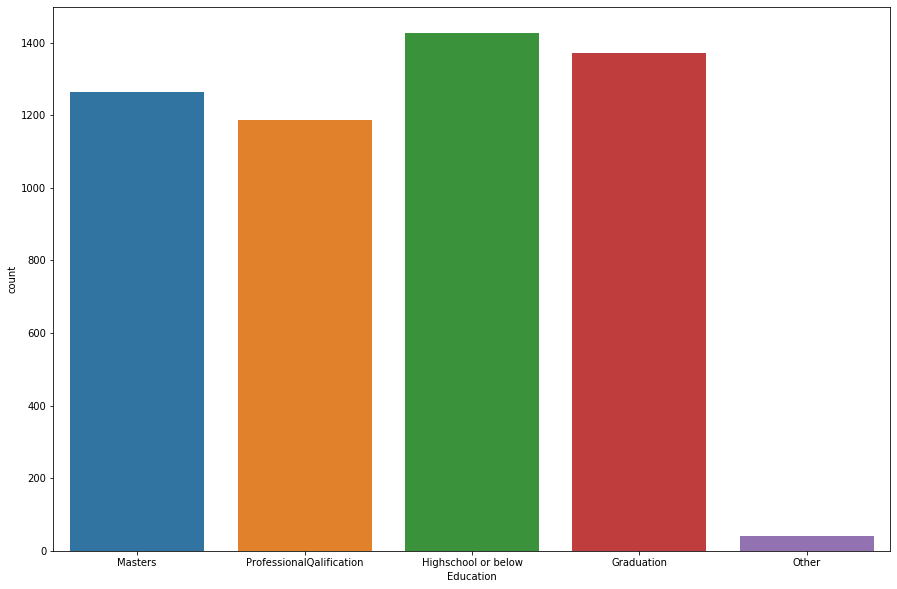

In [17]:
#distribution of education
fig, ax = plt.subplots(figsize=(15,10)) 
sns.countplot(x="Education", data=train_account_demo)

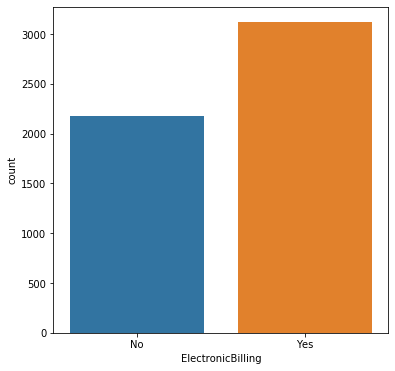

In [18]:
fig, ax = plt.subplots(figsize=(6,6)) 
sns.countplot(x="ElectronicBilling", data=train_account_demo)

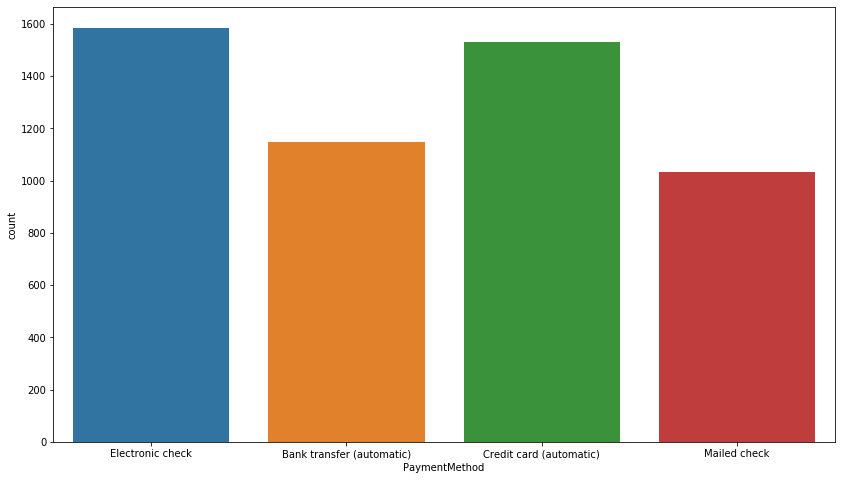

In [19]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.countplot(x="PaymentMethod", data=train_account_demo)

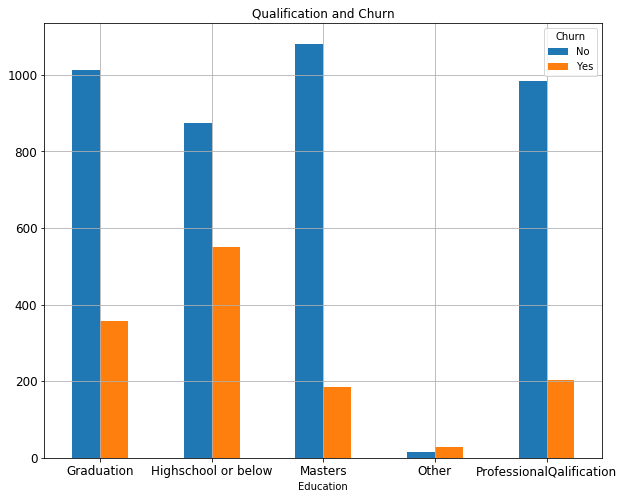

In [20]:
train_account_demo_group = train_account_demo.groupby(['Education','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(10,8),
                                   title='Qualification and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

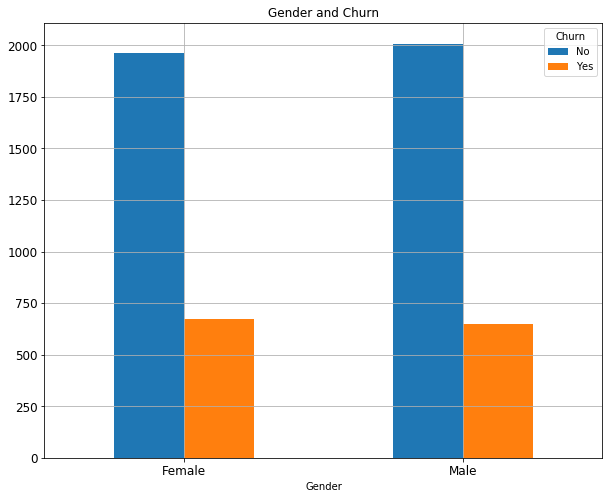

In [21]:
train_account_demo_group = train_account_demo.groupby(['Gender','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(10,8),
                                   title='Gender and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

In [22]:
#lets do downsampling as the data is highly imbalanced
yes_train = train_account_demo[train_account_demo.Churn == "Yes"]
yes_train.reset_index(inplace=True,drop=True)
no_train = train_account_demo[train_account_demo.Churn == "No"]
no_train.reset_index(inplace=True,drop=True)
print(yes_train.shape)
print(no_train.shape)
no_train_1324 = no_train.sample(1324)
train_final = yes_train.append(no_train_1324)
print((train_final.shape))
train_final.head(2)

(1324, 25)
(3974, 25)
(2648, 25)


,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1205,1,1,1,0,0,0,0,0,0,...,ProfessionalQalification,Female,372.5,5-1-2012,372.5,6-Dec-11,Yes,Month-to-month,Electronic check,Yes
1,Cust1213,1,1,1,0,0,0,0,0,0,...,ProfessionalQalification,Female,397.0,5-1-2012,1223.25,7-Oct-11,Yes,Month-to-month,Electronic check,Yes


# Missing Value Imputation¶


In [23]:
#Number of missng values in each clumn
train_final.isnull().sum()

CustomerID                               0
TypeOfService_DeviceProtection           0
TypeOfService_HasPhoneService            0
TypeOfService_InternetServiceCategory    0
TypeOfService_StreamingMovies            0
TypeOfService_StreamingTelevision        0
TypeOfService_OnlineBackup               0
TypeOfService_OnlineSecurity             0
TypeOfService_MultipleLines              0
TypeOfService_TechnicalSupport           0
Country                                  0
State                                    0
Retired                                  0
HasPartner                               0
HasDependents                            0
Education                                6
Gender                                   2
BaseCharges                              0
DOC                                      0
TotalCharges                             2
DOE                                      0
ElectronicBilling                        0
ContractType                             2
PaymentMeth

In [24]:
#now lets do missing value analysis
train_final[train_final.Country == "?"]
#there are only two records which have country as ?
#it is evident from state that the country is INDIA
train_final.Country[train_final.Country == "?"] = "India"

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
#having look at state values
print(train_final.State.value_counts())
train_final[train_final.State == "?"]

Maharashtra    2644
?                 4
Name: State, dtype: int64


,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
664,Cust3825,1,1,1,1,1,1,0,0,0,...,Graduation,Female,501.25,5-1-2012,11938.75,16-Dec-09,Yes,Month-to-month,Electronic check,Yes
1268,Cust6152,1,1,1,1,0,0,0,0,0,...,Masters,Female,276.00,5-1-2012,2641.75,11-Mar-11,No,Month-to-month,Credit card (automatic),Yes
2342,Cust4344,1,1,0,0,0,0,0,0,0,...,Graduation,Female,131.50,5-1-2012,8817.75,6-May-06,Yes,One year,Electronic check,No
3289,Cust5619,1,1,0,0,0,0,0,0,0,...,Graduation,Female,155.25,5-1-2012,5631.75,20-Jan-09,No,Two year,Bank transfer (automatic),No


In [26]:
#we can replace ? with maharastra as the whole data consists only maharashtra
train_final.State[train_final.State == "?"] = "Maharashtra"

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
#as the NA values are less for other columns
#replacing NA with mode for every column
for column in train_final.columns:
    train_final[column].fillna(train_final[column].mode()[0], inplace=True)

In [28]:
#replacing the MISSINGVAL in totalcharges column with the minimum value of the column i.e 100
#print(train_final.TotalCharges.min())
train_final.TotalCharges[train_final.TotalCharges == "MISSINGVAL"] =100
#train_final['TotalCharges'] = train_final['TotalCharges'].map({'MISSINGVAL': 100})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data Pre-processing

In [29]:
#changing the dates to proper format at then creating a new attribute which will give the tenure of the customer
train_final['DOC'] = pd.to_datetime(train_final['DOC'], format='%d-%m-%Y')

train_final['DOE']=train_final.DOE.apply(
    lambda x: pd.to_datetime(x).strftime('%d-%b-%Y'))

train_final['DOE']=pd.to_datetime(train_final['DOE'], format='%d-%b-%Y')

train_final['tenure'] = (train_final['DOC']-train_final['DOE']).dt.days


In [30]:
#Now lets convert the dataframe columns into the respective format

categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

#"Retired","HasPartner","HasDependents","Education","Gender","BaseCharges","TotalCharges",
#                         "ElectronicBilling","ContractType"


numericalFeatureNames = ["TotalCharges","BaseCharges","tenure"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    train_final[var] = train_final[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    train_final[nar] = train_final[nar].astype("float64")

In [31]:
train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
y = train_final[['Churn']]

In [32]:
train_final = pd.get_dummies(train_final, prefix=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

data_final = train_final.drop(['CustomerID','Country','State','DOC','DOE','Churn'], axis=1)

In [35]:
#visualization on the typed of objects in dataframe
dataTypeDf = pd.DataFrame(train_final.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})

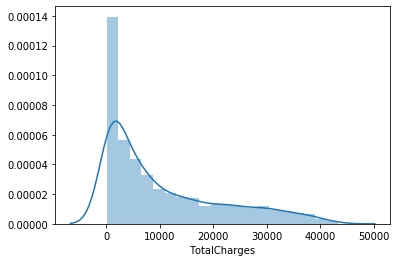

In [38]:
sns.distplot(data_final.TotalCharges)

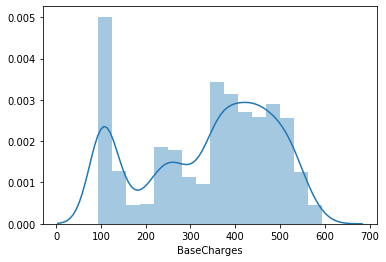

In [39]:
sns.distplot(data_final.BaseCharges)


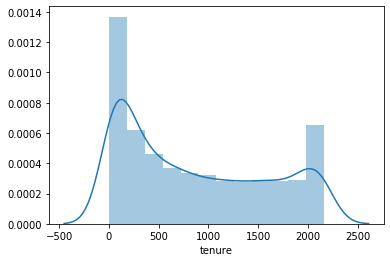

In [40]:
sns.distplot(data_final.tenure)

# Test Data

In [41]:
train = pd.read_csv("Test.csv")
Test_AccountInfo = pd.read_csv("Test_AccountInfo.csv")
Test_Demographics = pd.read_csv("Test_Demographics.csv")
Test_ServicesOptedFor = pd.read_csv("Test_ServicesOptedFor.csv")

In [42]:
#merging two dataframes with customerid attribute
test_test_account= pd.merge(Test_AccountInfo,train,on="CustomerID")
#renaming a column to match
Test_Demographics = Test_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
test_account_demo = pd.merge(Test_Demographics,test_test_account, on="CustomerID")

In [43]:
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "0"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"

In [44]:
yes_test_service = Test_ServicesOptedFor[Test_ServicesOptedFor.SeviceDetails != 'No']
yes_test_service = yes_test_service.sort_values(by=['TypeOfService'], ascending=['True'])
fff = pd.get_dummies(yes_test_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])

In [45]:
xxx = fff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
xxx.columns = xxx.columns.droplevel()
xxx.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
xxx = xxx.replace({'Yes': 1, None: 0})
test_account_demo = pd.merge(xxx,test_account_demo, on="CustomerID",how='inner')
test_account_demo.head(2)

,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod
0,Cust11201,1,1,1,1,0,0,0,0,0,...,2,Graduation,Male,284.75,5-1-2012,9447.5,21-Mar-09,No,One year,Mailed check
1,Cust11202,1,1,1,1,0,0,0,0,0,...,1,Masters,Male,280.75,5-1-2012,17439.75,2-Dec-06,No,One year,Bank transfer (automatic)


In [46]:
test_account_demo.isnull().sum()

CustomerID                               0
TypeOfService_DeviceProtection           0
TypeOfService_HasPhoneService            0
TypeOfService_InternetServiceCategory    0
TypeOfService_StreamingMovies            0
TypeOfService_StreamingTelevision        0
TypeOfService_OnlineBackup               0
TypeOfService_OnlineSecurity             0
TypeOfService_MultipleLines              0
TypeOfService_TechnicalSupport           0
Country                                  0
State                                    0
Retired                                  0
HasPartner                               0
HasDependents                            0
Education                                4
Gender                                   1
BaseCharges                              0
DOC                                      0
TotalCharges                             0
DOE                                      0
ElectronicBilling                        0
ContractType                             1
PaymentMeth

In [47]:
#as the NA values are less 
#replacing NA with mode for every column
for column in test_account_demo.columns:
    test_account_demo[column].fillna(test_account_demo[column].mode()[0], inplace=True)


In [48]:
test_account_demo.Country[test_account_demo.Country == "?"] = "India"
test_account_demo.TotalCharges[test_account_demo.TotalCharges == "MISSINGVAL"] = 100

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
#changing the dates to proper format at then creating a new attribute which will give the tenure of the customer
test_account_demo['DOC'] = pd.to_datetime(test_account_demo['DOC'], format='%d-%m-%Y')

test_account_demo['DOE']=test_account_demo.DOE.apply(
    lambda x: pd.to_datetime(x).strftime('%d-%b-%Y'))

test_account_demo['DOE']=pd.to_datetime(test_account_demo['DOE'], format='%d-%b-%Y')

test_account_demo['tenure'] = (test_account_demo['DOC']-test_account_demo['DOE']).dt.days

In [50]:
#Now lets convert the dataframe columns into the respective format

categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

#"Retired","HasPartner","HasDependents","Education","Gender","BaseCharges","TotalCharges",
#                         "ElectronicBilling","ContractType"


numericalFeatureNames = ["TotalCharges","BaseCharges","tenure"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    test_account_demo[var] = test_account_demo[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    test_account_demo[nar] = test_account_demo[nar].astype("float64")

In [51]:
test_account_demo = pd.get_dummies(test_account_demo, prefix=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

test_final = test_account_demo.drop(['CustomerID','Country','State','DOC','DOE'], axis=1)
test_final['PaymentMethod_Credit card (automatic)'] = 0

In [52]:
test_final.shape


(1769, 34)

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data_final, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1986, 34)
(662, 34)
(1986, 1)
(662, 1)


# Random Forest

In [57]:
#initializing reandom forest
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=600)
RF_clf.fit(X_train, y_train)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
#predicting on train and test data
#RF_clf.fit(X_train_dtm, y_train)
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_rf_pred_test))
#confusion_matrix = confusion_matrix(y_test, y_rf_pred_test)
#print(confusion_matrix)
print(metrics.accuracy_score(y_test, y_rf_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       336
           1       0.74      0.78      0.76       326

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662

0.7583081570996979


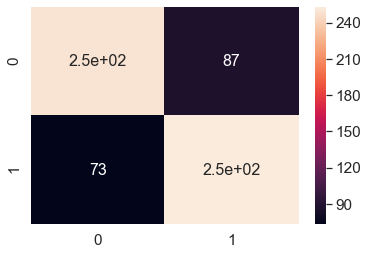

In [59]:
cm = metrics.confusion_matrix(y_test, y_rf_pred_test)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16})# font size

In [60]:
probs_rf = RF_clf.predict_proba(test_final)
probs = probs_rf[:,1]  #taking a column
probs[probs > 0.25] =1  #setting thresholds
probs[probs <= 0.25] = 0
submission = test_account_demo[["CustomerID"]]
submission['Churn'] = probs
submission['Churn'] = submission['Churn'].map({1:"Yes",0:"No"})
#train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
submission.to_csv("predictions.csv",index=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [61]:
y_rf_pred_train = RF_clf.predict(X_train)
jj = RF_clf.predict_proba(X_test)
probs_rf = jj[:,1]  #taking a column
probs_rf[probs_rf > 0.60] =1  #setting thresholds
probs_rf[probs_rf <= 0.60] = 0
y_rf_pred_test = RF_clf.predict(X_test)
print(metrics.accuracy_score(y_test, probs_rf))
print(classification_report(y_test, probs_rf))

0.756797583081571
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       336
           1       0.80      0.68      0.73       326

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.75       662
weighted avg       0.76      0.76      0.76       662



# Logistic regression

In [62]:
from sklearn.linear_model import LogisticRegression
seed=12
logreg = LogisticRegression(C=1, random_state=12, class_weight='balanced')

In [63]:
logreg.fit(X_train, y_train)


/Users/rasheshkothari/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rasheshkothari/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

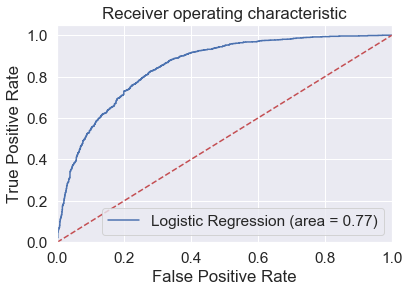

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y, logreg.predict_proba(data_final)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [65]:
y_log_pred_train = logreg.predict(X_train)
ii = logreg.predict_proba(X_test)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.6] =1  #setting thresholds
probs_log[probs_log <= 0.60] = 0
y_log_pred_test = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, probs_log))
print(classification_report(y_test, probs_log))

0.7583081570996979
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       336
           1       0.77      0.72      0.75       326

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662



with 0.35 accuracy is 73 and recall is 89%

In [66]:
y_log_pred_train = logreg.predict(X_train)
ii = logreg.predict_proba(X_test)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.25] =1  #setting thresholds
probs_log[probs_log <= 0.25] = 0
y_log_pred_test = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, probs_log))
print(classification_report(y_test, probs_log))

0.7099697885196374
              precision    recall  f1-score   support

           0       0.90      0.48      0.63       336
           1       0.64      0.94      0.76       326

    accuracy                           0.71       662
   macro avg       0.77      0.71      0.70       662
weighted avg       0.77      0.71      0.69       662



# Decision Tree

In [76]:
!conda install -c conda-forge graphviz --yes 

Solving environment: done

# All requested packages already installed.



In [80]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_final, y)

In [81]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# With Standardization

In [82]:
#combining train and test data to do standardizing for numerical attributes
ff = pd.concat([data_final,test_final],ignore_index=True)
yy =  ff[['tenure','TotalCharges','BaseCharges']]

from sklearn import preprocessing
x = yy.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['tenure','TotalCharges','BaseCharges']
ff['tenure'] = df['tenure']
ff['TotalCharges'] = df['TotalCharges']
ff['BaseCharges'] = df['BaseCharges']
jj = ff.head(2648)
jj.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(2648, 34)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(jj, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1986, 34)
(662, 34)
(1986, 1)
(662, 1)


In [84]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=600)
RF_clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
#predicting on train and test data
#RF_clf.fit(X_train_dtm, y_train)
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_rf_pred_test))
#confusion_matrix = confusion_matrix(y_test, y_rf_pred_test)
#print(confusion_matrix)
print(metrics.accuracy_score(y_test, y_rf_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       336
           1       0.75      0.77      0.76       326

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662

0.7598187311178247


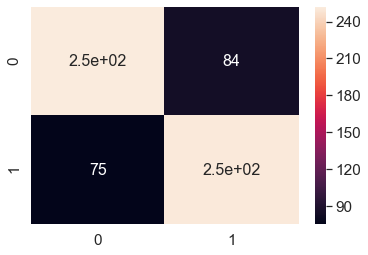

In [87]:
cm = metrics.confusion_matrix(y_test, y_rf_pred_test)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16})# font size

In [88]:
probs_rf = RF_clf.predict_proba(test_final)
probs = probs_rf[:,1]  #taking a column
probs[probs > 0.5] =1  #setting thresholds
probs[probs <= 0.5] = 0
submission = test_account_demo[["CustomerID"]]
submission['Churn'] = probs
submission['Churn'] = submission['Churn'].map({1:"Yes",0:"No"})
#train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
#submission.to_csv("predictions.csv",index=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
